#Content Based Recommendations

Content-based recommendation systems are a popular technique in machine learning and are highly dependent on the inputs provided by users. These systems use the content or attributes of the items you like, referred to as “content”, to make recommendations1. They suggest similar items based on a particular item using item metadata, such as genre, director, description, actors, etc.

For example, if you’ve interacted with a particular type of movie before, a content-based recommendation system will recommend movies that share similar properties3. This system can adapt to the introduction of new items and isn’t hampered by the cold-start problem.


Content-based recommendation systems have several advantages over rank-based and knowledge-based systems:

1. **Personalization**: Content-based systems provide personalized recommendations by analyzing a user's past behavior and preferences. This allows the system to capture the specific interests of a user, and can recommend niche items that very few other users are interested in.

2. **Independence**: These systems do not require data about other users, since the recommendations are specific to the individual user. This makes it easier to scale to a large number of users.

3. **Transparency**: The recommendations made by content-based systems are transparent to the user, as they are based on the user's own activity and preferences.

4. **Avoiding the Cold Start Problem**: Content-based recommendation systems work best when you need to avoid cold starts for any products you add to your website. Any new item added can be listed and recommended from there.

5. **Relevance**: Recommendations are highly relevant to the user, as they are based on similarity between items and the user's activity.




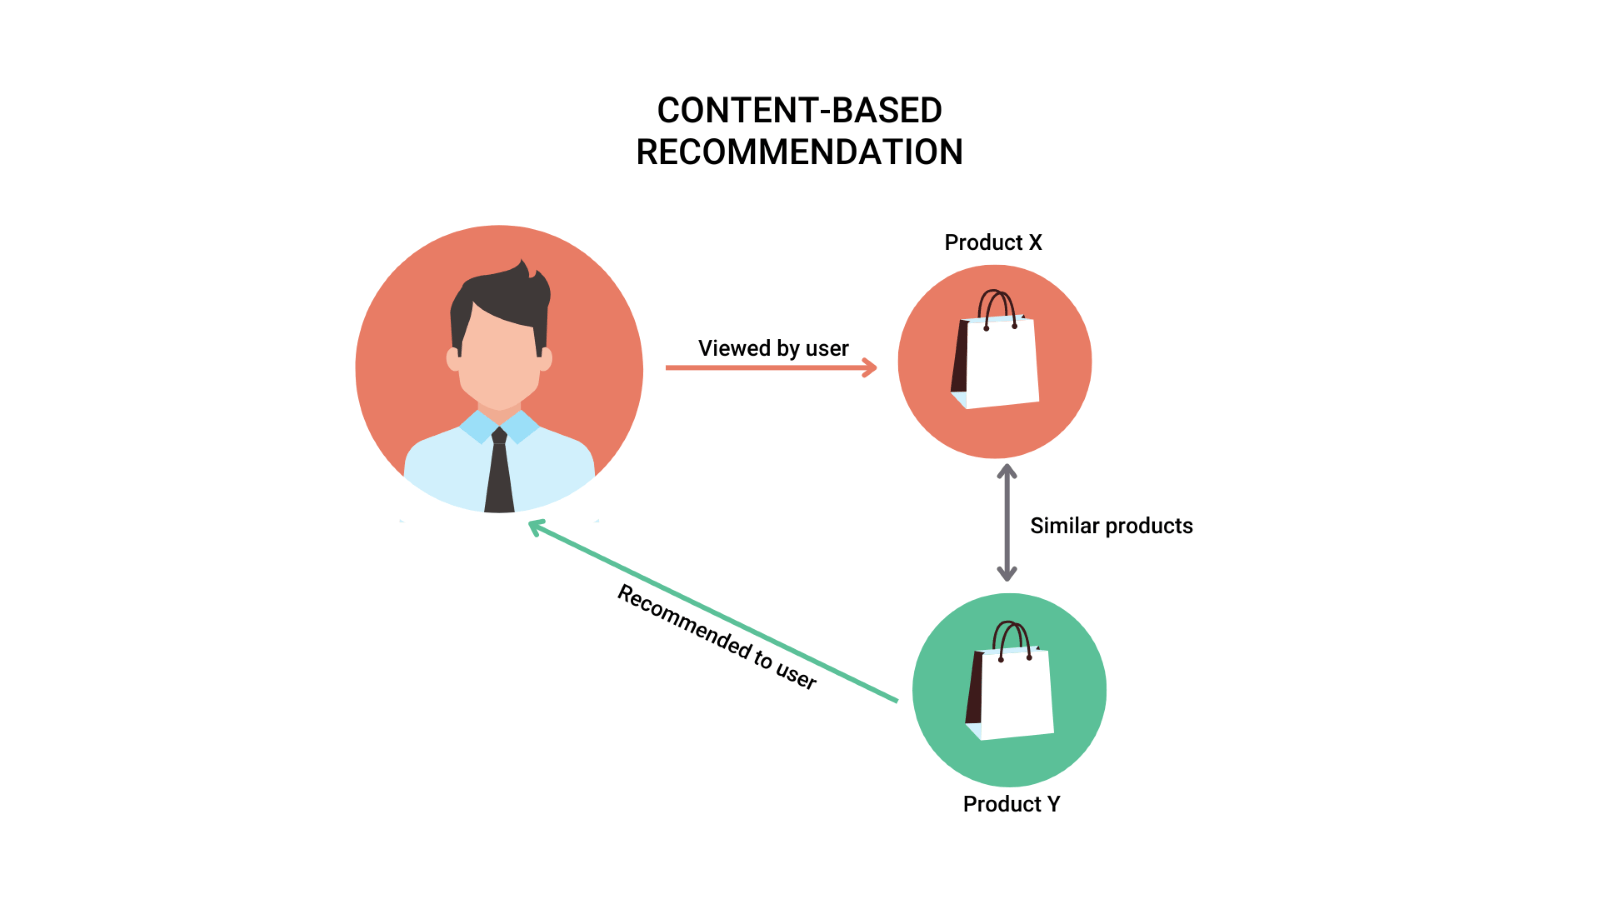

### Import necessary libraries & Load the datasets

In [ ]:
# Import necessary libraries
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
# Enable inline plotting for Jupyter notebooks
%matplotlib inline
import pickle # Import the pickle library for serializing and deserializing Python objects.


In [ ]:
# Read in the datasets
movies = pd.read_csv('/content/drive/MyDrive/movies_clean.csv')
reviews = pd.read_csv('/content/drive/MyDrive/reviews_clean.csv')
all_recs = pickle.load(open("/content/drive/MyDrive/all_recs.p", "rb"))
del movies['Unnamed: 0']
del reviews['Unnamed: 0']

In [ ]:
reviews.head()

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-12 23:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 01:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,422720,8,1412178746,2014-10-01 15:52:26,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2,454876,8,1394818630,2014-03-14 17:37:10,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2,790636,7,1389963947,2014-01-17 13:05:47,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


The datasets description:

`a.` **movies** - a dataframe of all of the movies in the dataset along with other content related information about the movies (genre and date)


`b.` **reviews** - this was the main dataframe used before for collaborative filtering, as it contains all of the interactions between users and movies.


`c.` **all_recs** - a dictionary where each key is a user, and the value is a list of movie recommendations based on collaborative filtering

For the individuals in **all_recs** who did receive 10 recommendations using collaborative filtering, we don't really need to worry about them.  However, there were a number of individuals in our dataset who did not receive any recommendations.



 Let's start with finding all of the users in our dataset 'all_recs ' who didn't get all 10 ratings we would have liked them to have using collaborative filtering.

In [ ]:
# Store users who still need recommendations here
users_who_need_recs = [key for key, values in all_recs.items() if len(values) < 10]


Before finding recommendations, will rank the user's ratings from highest to lowest.

In [116]:
# create a dataframe similar to reviews, but ranked by rating for each user
sorted_reviews = reviews.groupby('user_id').apply(pd.DataFrame.sort_values, 'rating', ascending=False)

In [ ]:
sorted_reviews.head()

user_id  movie_id  rating   timestamp                 date  \
user_id                                                                  
1       0         1     68646      10  1381620027  2013-10-12 23:20:27   
        1         1    113277      10  1379466669  2013-09-18 01:11:09   
2       18        2   2024544      10  1389355949  2014-01-10 12:12:29   
        16        2   1798709      10  1389948338  2014-01-17 08:45:38   
        22        2   2726560       9  1438293988  2015-07-30 22:06:28   

            month_1  month_2  month_3  month_4  month_5  ...  month_9  \
user_id                                                  ...            
1       0         0        0        0        0        0  ...        0   
        1         0        0        0        0        0  ...        0   
2       18        0        0        0        0        0  ...        0   
        16        0        0        0        0        0  ...        0   
        22        0        0        0        0        0  ...        0   

            month_10  month_11  month_12  year_2013  year_2014  year_2015  \
user_id                                                                     
1       0          1         0         0          1          0          0   
        1          0         0         0          1          0          0   
2       18         0         0         0          0          1          0   
        16         0         0         0          0          1          0   
        22         0         0         0          0          0          1   

            year_2016  year_2017  year_2018  
user_id                                      
1       0           0          0          0  
        1           0          0          0  
2       18          0          0          0  
        16          0          0          0  
        22          0          0          0  

[5 rows x 23 columns]

#### Similarities

we can obtain a matrix of how similar movies are to one another by taking the dot product of this matrix with itself.

We can perform the dot product on a matrix of movies with content characteristics to provide a movie by movie matrix where each cell is an indication of how similar two movies are to one another.

In [ ]:
# Subset so movie_content is only using the dummy variables for each genre and the 3 century based year dummy columns
movie_content = np.array(movies.iloc[:,4:])
# Calculate the similarity matrix
similarity_matrix = np.dot(movie_content, movie_content.T)
# Set the diagonal elements to 0 to remove self-similarity
np.fill_diagonal(similarity_matrix, 0)

By now, we have two essential matrices. The first matrix is structured in a way where each user's ratings are meticulously ordered. The second matrix takes movies as its axes, with entries reflecting the degree of similarity between them – the larger the entry, the more akin the two movies, and conversely, the smaller the entry, the more distinct they are. This matrix serves as a reliable measure of content similarity, and it's the linchpin of our recommendation process.

Now, it's time to delve into the exciting part of the recommendation system. For each user, we will follow these steps:

    i. For every movie in their history, we will identify the movies that are most similar to them and which the user hasn't seen yet.

    ii. We will continue this process through the user's rated movies until we've accumulated 10 recommendations or until there are no more unseen movies left to suggest."

In [83]:
def find_similar_movies(movie_id):
    '''
    INPUT
    movie_id - a movie_id
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    # find the row of each movie id
    movie_idx =movies[movies['movie_id'] == movie_id].index[0]

    # find the most similar movie indices - to start I said they need to be the same for all content
    max_similarity = np.max(similarity_matrix[movie_idx])
    most_similar_indices = np.where(similarity_matrix[movie_idx] == max_similarity)[0]
    # pull the movie titles based on the indices
    similar_movies = movies.iloc[most_similar_indices]['movie'].to_list()
    return similar_movies

In [91]:
# Test the function with a mock movie ID
movie_id_to_test = 10
similar_movies = find_similar_movies(movie_id_to_test)
similar_movies




['Edison Kinetoscopic Record of a Sneeze (1894)',
 'The Arrival of a Train (1896)',
 'Annabelle Serpentine Dance (1895)',
 'Roundhay Garden Scene (1888)',
 'Llandudno Happy Valley and Minstrel Show (1898)']

In [99]:
id =10
list(movies[movies["movie_id"]==id]['movie'].values)

['La sortie des usines Lumière (1895)']

In [109]:
def get_movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids

    '''
    # return a list with movie names for the list of input movie IDs
    movie_lst=[]
    for movie_id in movie_ids:
      movie_lst.append(movies[movies["movie_id"]==movie_id]['movie'].values[0])
    return movie_lst

In [111]:
# Test the function
movie_ids_to_get = [10,1798709,68646]
movie_names = get_movie_names(movie_ids_to_get)
print(movie_names)

['La sortie des usines Lumière (1895)', 'Her (2013)', 'The Godfather (1972)']


In [134]:
def make_recs():
    '''
    INPUT
    None
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    # Create dictionary to return with users and ratings
    recs = {}

    # For each user
    for user in users_who_need_recs:

        # Pull only the reviews the user has seen
        user_reviews = reviews[reviews['user_id'] == user]

        # Look at each of the movies (highest ranked first),
        # pull the movies the user hasn't seen that are most similar
        # These will be the recommendations - continue until 10 recs
        # or you have depleted the movie list for the user
        recs[user] = []
        for movie_id in sorted_reviews.loc[user]['movie_id']:
            if len(recs[user]) < 10:
                similar_movies = find_similar_movies(movie_id)
                unseen_movies = [movie for movie in similar_movies if movie not in user_reviews['movie_id']]
                recs[user].extend(unseen_movies)
            else:
                break

    return recs


In [137]:
# Test the function
recommendations = make_recs()


In [139]:
# Get the first key-value pair in the dictionary
first_key = list(recommendations.keys())[0]
first_value = recommendations[first_key]

# Print the first key-value pair
print(f"user_id: {first_key}")
print(f"the recommended movies: {first_value}")

user_id: 26
the recommended movies: ["Don's Plum (2001)", 'State and Main (2000)', 'Sånger från andra våningen (2000)', 'Return to Me (2000)', 'Bruno (2000)', 'Committed (2000)', 'High Fidelity (2000)', 'The Next Best Thing (2000)', 'Ghost World (2001)', 'Hanging Up (2000)', 'Interstate 60: Episodes of the Road (2002)', 'Memórias Póstumas (2001)', 'Keeping the Faith (2000)', 'Nurse Betty (2000)', 'Sunset Strip (2000)', 'Almost Famous (2000)', 'Wonder Boys (2000)', 'Down to You (2000)', 'Pantaleón y las visitadoras (2000)', 'The Fighting Temptations (2003)', '28 Days (2000)', 'Badding (2000)', 'Panic (2000)', 'Where the Heart Is (2000)', 'Riding in Cars with Boys (2001)', 'Trasgredire (2000)', 'Beautiful Joe (2000)', 'Coyote Ugly (2000)', 'Rock Star (2001)', 'Two Family House (2000)', 'Tillsammans (2000)', 'Boys and Girls (2000)', 'Dr. T and the Women (2000)', 'Thomas and the Magic Railroad (2000)', 'AmnesiA (2001)', 'The Dish (2000)', 'My First Mister (2001)', "Was tun, wenn's brennt? 

The make_recs function is designed to recommend movies to a user based on the movies they’ve already rated. However, it doesn’t take into account the actual ratings of the movies. It simply recommends movies that are similar to the ones the user has seen, regardless of whether the user liked those movies or not.

If you want to recommend only movies that are similar to the ones the user has rated highly, you could modify your function to consider only the movies that the user has given a high rating. Here’s how you could do this:

In [144]:
def make_recs_based_on_ratings():
    '''
    INPUT
    None
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    # Create dictionary to return with users and ratings
    recs = {}

    # For each user
    for user in users_who_need_recs:

        # Pull only the reviews the user has seen and rated highly
        user_reviews = reviews[(reviews['user_id'] == user) & (reviews['rating'] >= 8)]  # assuming ratings are on a scale of 1-10

        # Look at each of the movies (highest ranked first),
        # pull the movies the user hasn't seen that are most similar
        # These will be the recommendations - continue until 10 recs
        # or you have depleted the movie list for the user
        recs[user] = []
        for movie_id in sorted_reviews.loc[user]['movie_id']:
            if len(recs[user]) < 10:
                similar_movies = find_similar_movies(movie_id)
                unseen_movies = [movie for movie in similar_movies if movie not in user_reviews['movie_id']]
                recs[user].extend(unseen_movies)
            else:
                break

    return recs


In [143]:
# Test the function
recommendations_with_ratings = make_recs_based_on_ratings()


In [145]:
# Get the first key-value pair in the dictionary
first_key = list(recommendations_with_ratings.keys())[0]
first_value = recommendations_with_ratings[first_key]

# Print the first key-value pair
print(f"user_id: {first_key}")
print(f"the recommended movies: {first_value}")

user_id: 26
the recommended movies: ["Don's Plum (2001)", 'State and Main (2000)', 'Sånger från andra våningen (2000)', 'Return to Me (2000)', 'Bruno (2000)', 'Committed (2000)', 'High Fidelity (2000)', 'The Next Best Thing (2000)', 'Ghost World (2001)', 'Hanging Up (2000)', 'Interstate 60: Episodes of the Road (2002)', 'Memórias Póstumas (2001)', 'Keeping the Faith (2000)', 'Nurse Betty (2000)', 'Sunset Strip (2000)', 'Almost Famous (2000)', 'Wonder Boys (2000)', 'Down to You (2000)', 'Pantaleón y las visitadoras (2000)', 'The Fighting Temptations (2003)', '28 Days (2000)', 'Badding (2000)', 'Panic (2000)', 'Where the Heart Is (2000)', 'Riding in Cars with Boys (2001)', 'Trasgredire (2000)', 'Beautiful Joe (2000)', 'Coyote Ugly (2000)', 'Rock Star (2001)', 'Two Family House (2000)', 'Tillsammans (2000)', 'Boys and Girls (2000)', 'Dr. T and the Women (2000)', 'Thomas and the Magic Railroad (2000)', 'AmnesiA (2001)', 'The Dish (2000)', 'My First Mister (2001)', "Was tun, wenn's brennt? 